# Constructing the forward model

This section will cover how to contruct the head model (the forward model implemented as a lead field matrix) to be used in source modeling. This will done based on the structural T1 MRI. The model will be alinged to head postion of the subject in the MEG system. Note that this seciton requires access to FreeSurfer (a Unix/Linux software). For more details see https://mne.tools/stable/auto_tutorials/forward/30_forward.html

## Preparation

Import the relevant Python modules:

In [2]:
import os.path as op
import mne
import os

Then set the file names and paths:

In [3]:
data_path = r'C:\Users\JensenO\Dropbox\FLUX\Development\dataRaw'
result_path = r'C:\Users\JensenO\Dropbox\FLUX\Development\dataResults'
file_name = 'training_raw-1.fif'

path_file  = op.join(data_path,file_name)

mri_dir = r'C:\Users\jenseno\Dropbox\FLUX\Development\dataRaw\MRI'
subject = 'training1'  

## Perform surface reconstruction using FreeSurfer and MNE:

A first requirement is that the MRI data are in NifTI (.nii) format. Converion from DICOM  to NifTI can be done e.g. using [MRIcro](https://people.cas.sc.edu/rorden/mricro/mricro.html)
The NifTI file for this tutorial is *T1_anon_defaced.nii* . Its the T1 MRI which has been 'de-faced' in order to anonymize the data. 

[FreeSurfer](https://surfer.nmr.mgh.harvard.edu/) provides the functionality for performing the cortical reconstuction using the [recon-all](https://surfer.nmr.mgh.harvard.edu/fswiki/recon-all/). 

This must be done in Unix/Linux:

> recon-all -i T1_anon_defaced.nii -s T1_anon_defaced -all


To perform the scalp surface reconstruction to be used in MNE-Python using the command from the terminal:

> mne make_scalp_surfaces --overwrite --subject T1_anon_defaced --force


To create the BEM, execute the terminal command:

> mne watershed_bem --overwrite --subject t1_anon_defaced
    
For a convinient batch script performing these commands see [my_recon.sh](https://github.com/Neuronal-Oscillations/FLUX/blob/main/MNEPython/my_recon.sh) on GitHub 
    

Now read and illustrate the brain surface generated from FreeSurfer: 

## Inspecting the surface reconstruction

In order to verify that the surface has been constructed and the fif-file created plot the output:

In [4]:
Brain = mne.viz.get_brain_class()

brain = Brain(subject, 
                  hemi='lh', 
                  surf='pial',
                  subjects_dir=mri_dir, 
                  size=(800, 600))

brain.add_annotation('aparc.a2009s', borders=False)

Using pyvistaqt 3d backend.



C:\Users\jenseno\Anaconda3\envs\mne\lib\site-packages\mne\viz\backends\_pyvista.py:41: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  VTK9 = LooseVersion(getattr(vtk, 'VTK_VERSION', '9.0')) >= LooseVersion('9.0')
C:\Users\jenseno\Anaconda3\envs\mne\lib\site-packages\mne\viz\backends\_pyvista.py:41: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  VTK9 = LooseVersion(getattr(vtk, 'VTK_VERSION', '9.0')) >= LooseVersion('9.0')
C:\Users\jenseno\Anaconda3\envs\mne\lib\site-packages\mne\viz\backends\_pyvista.py:192: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(pyvista.__version__) >= '0.27.0':



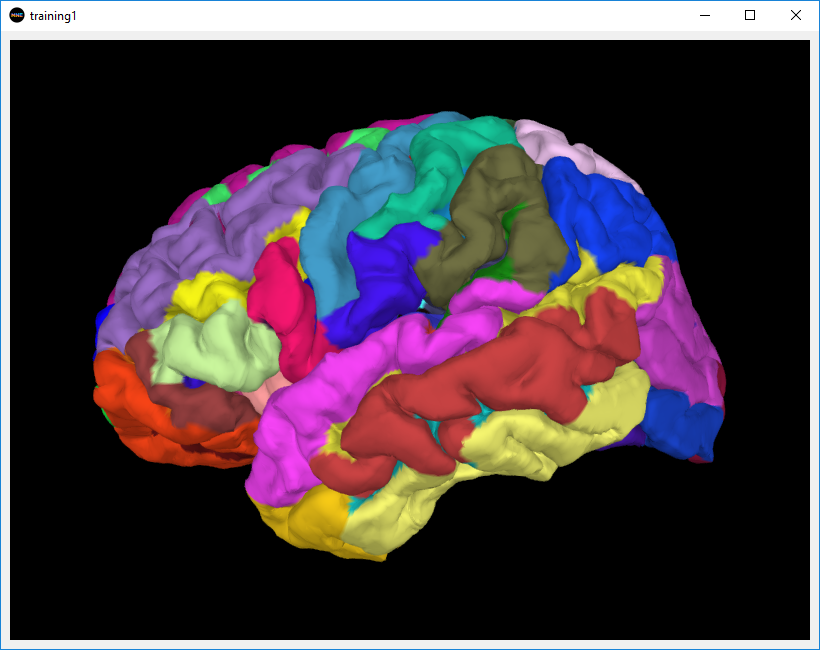

Above shows the parcellated brain surface. We are not going use the parcellation here; however, its wise to use the output to check that the brain surface has been correctly reconstructed. 

## Creating the boundary element model (BEM) surfaces

Now that the surface of the MRI has been recontructed the boundary element model (BEM) can be created. As this will be used for MEG source reconstruction, we will prepare a single shell model by setting *conductivity = (0.3,)* . the *ico* parameter serves to downsample the model and can be increased to reduce the computational demands. 

In [5]:
conductivity = (0.3,) 
model = mne.make_bem_model(subject,
                           ico=4,
                           conductivity=conductivity,
                           subjects_dir=mri_dir)
bem = mne.make_bem_solution(model)

Creating the BEM geometry...
Going from 5th to 4th subdivision of an icosahedron (n_tri: 20480 -> 5120)
inner skull CM is  -0.22 -26.75  24.03 mm
Surfaces passed the basic topology checks.
Complete.

Approximation method : Linear collocation

Homogeneous model surface loaded.
Computing the linear collocation solution...
    Matrix coefficients...
        inner skull (2562) -> inner skull (2562) ...
    Inverting the coefficient matrix...
Solution ready.
BEM geometry computations complete.


Now save the BEM model

In [6]:
fname_bem = 'training1-bem-sol.fif' 
mne.write_bem_solution(op.join(mri_dir,fname_bem),
                           bem,
                           overwrite=True)

Overwriting existing file.


and visualize

Using surface: C:\Users\jenseno\Dropbox\FLUX\Development\dataRaw\MRI\training1\bem\inner_skull.surf
Using surface: C:\Users\jenseno\Dropbox\FLUX\Development\dataRaw\MRI\training1\bem\outer_skull.surf
Using surface: C:\Users\jenseno\Dropbox\FLUX\Development\dataRaw\MRI\training1\bem\outer_skin.surf


C:\Users\jenseno\Anaconda3\envs\mne\lib\site-packages\mne\viz\utils.py:109: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


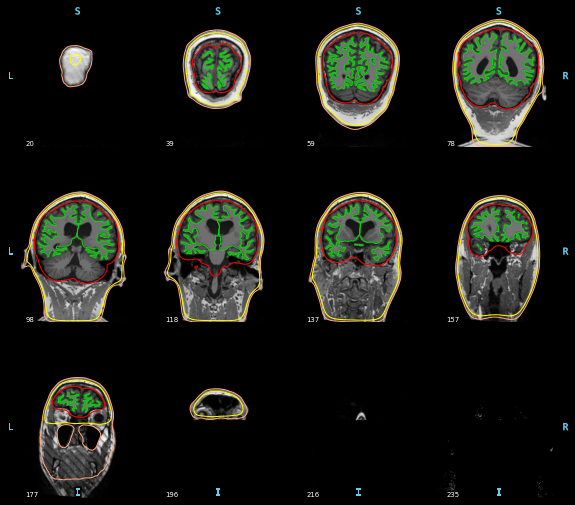

In [7]:
mne.viz.plot_bem(subject=subject,
                subjects_dir=mri_dir,
                brain_surfaces='white',
                orientation='coronal');

In the above plots please check that the brain surface has been identified correctly. 

## Co-registration with anatomical landmars 

The next step involves the spatial alignment of MEG sensor space in relation to digitized scalp landmarks,the HPI coils and the MRI volumes. This alignment is used when deriving the forward solution. It requires working with the MNE-Python-coregistration GUI software. Further support and explanations can be found here: https://www.slideshare.net/mne-python/mnepython-coregistration

In [ ]:
%matplotlib qt

VALUE = r'C:\Users\jenseno\Dropbox\FLUX\Development\dataRaw\MRI'
mne.utils.set_config("SUBJECTS_DIR", VALUE, set_env=True)
mne.gui.coregistration()

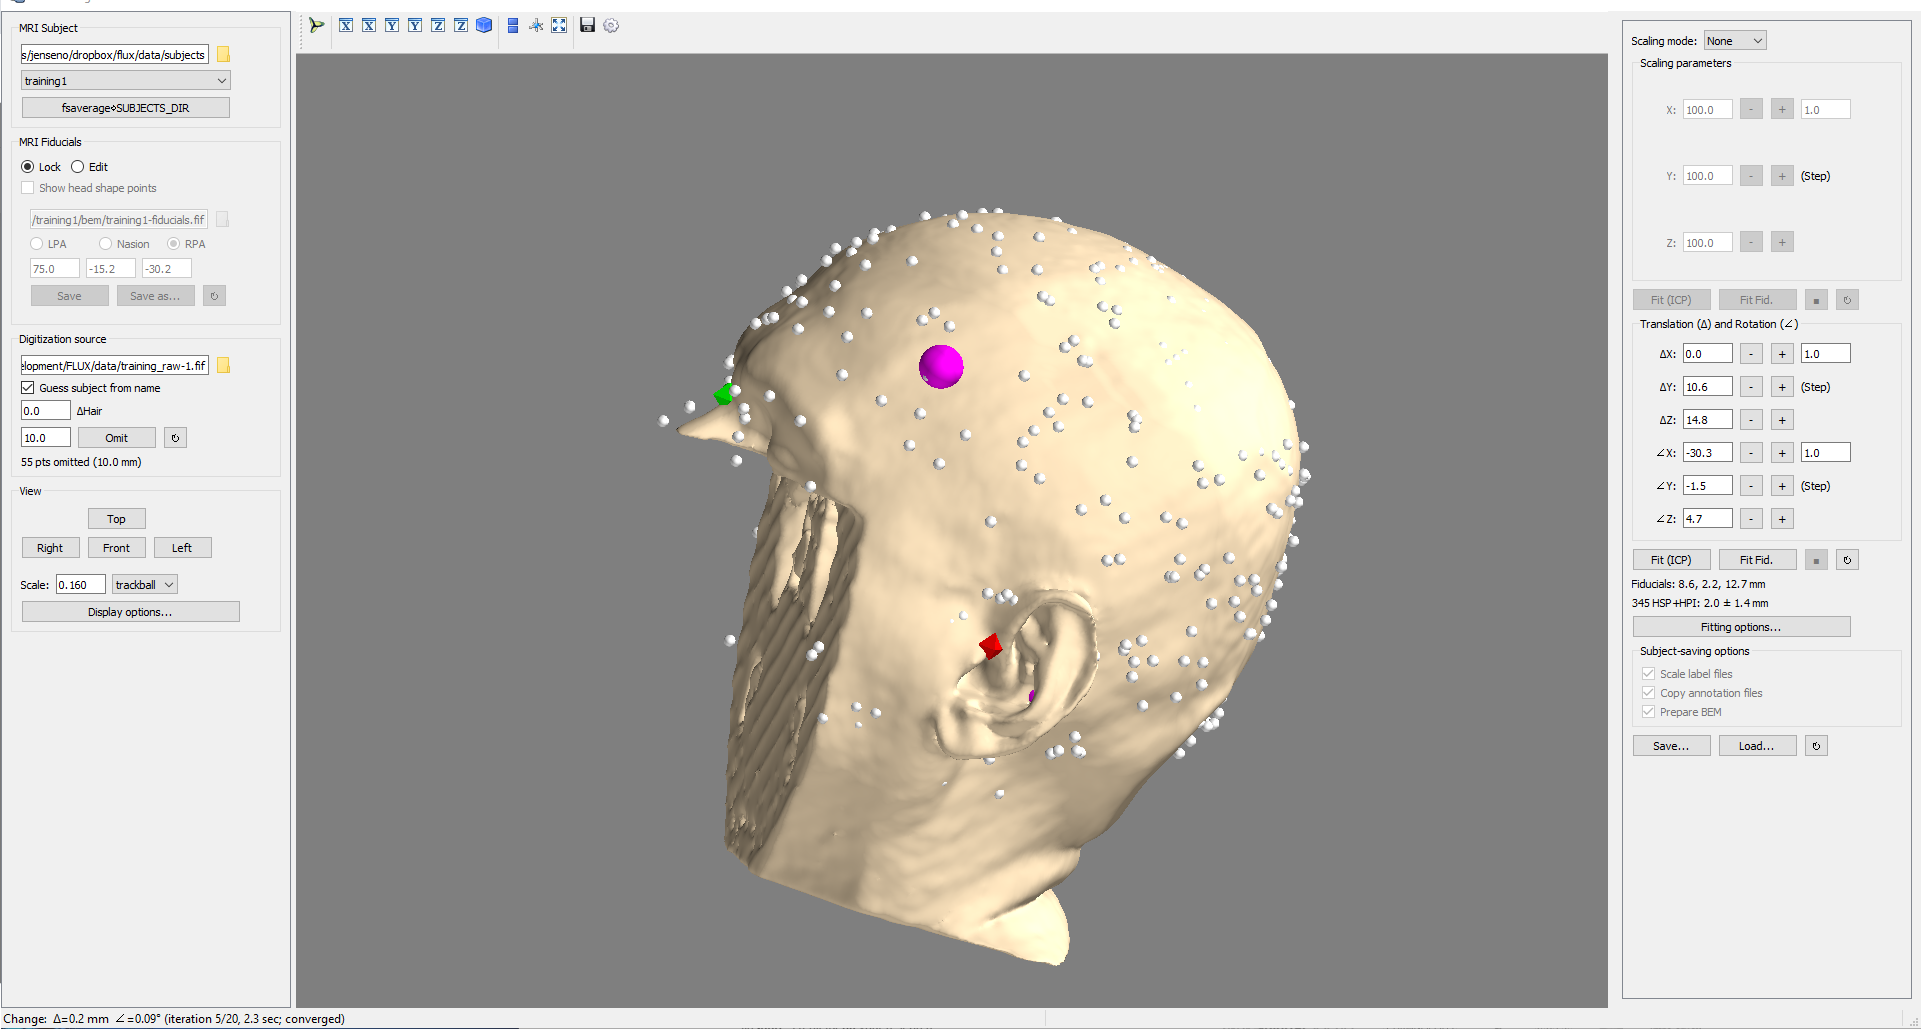

Note that we here set 'Omit' to 10 mm. This means that points with a distance 10 mm away from the surface are ignored. This is essential for the de-faced MRI.

Next, it is important to verify the alignment with respect to the MEG sensor array:

In [8]:
trans = 'trans.fif'
data_path = r'C:\Users\JensenO\Dropbox\FLUX\Development\dataResults'
trans_file = op.join(data_path,trans)
print(trans_file)

info = mne.io.read_info(path_file)
mne.viz.plot_alignment(info, trans_file, subject=subject, dig=True,
                           meg=['helmet', 'sensors'], subjects_dir=mri_dir,
                           surfaces='head-dense')

C:\Users\JensenO\Dropbox\FLUX\Development\dataResults\trans.fif
    Read a total of 8 projection items:
        generated with autossp-1.2.0 (1 x 306)  idle
        generated with autossp-1.2.0 (1 x 306)  idle
        generated with autossp-1.2.0 (1 x 306)  idle
        generated with autossp-1.2.0 (1 x 306)  idle
        generated with autossp-1.2.0 (1 x 306)  idle
        generated with autossp-1.2.0 (1 x 306)  idle
        generated with autossp-1.2.0 (1 x 306)  idle
        generated with autossp-1.2.0 (1 x 306)  idle
Getting helmet for system 306m
Using lh.seghead for head surface.


C:\Users\jenseno\Anaconda3\envs\mne\lib\site-packages\mne\viz\backends\_pyvista.py:192: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(pyvista.__version__) >= '0.27.0':


Channel types::	mag: 102, grad: 204


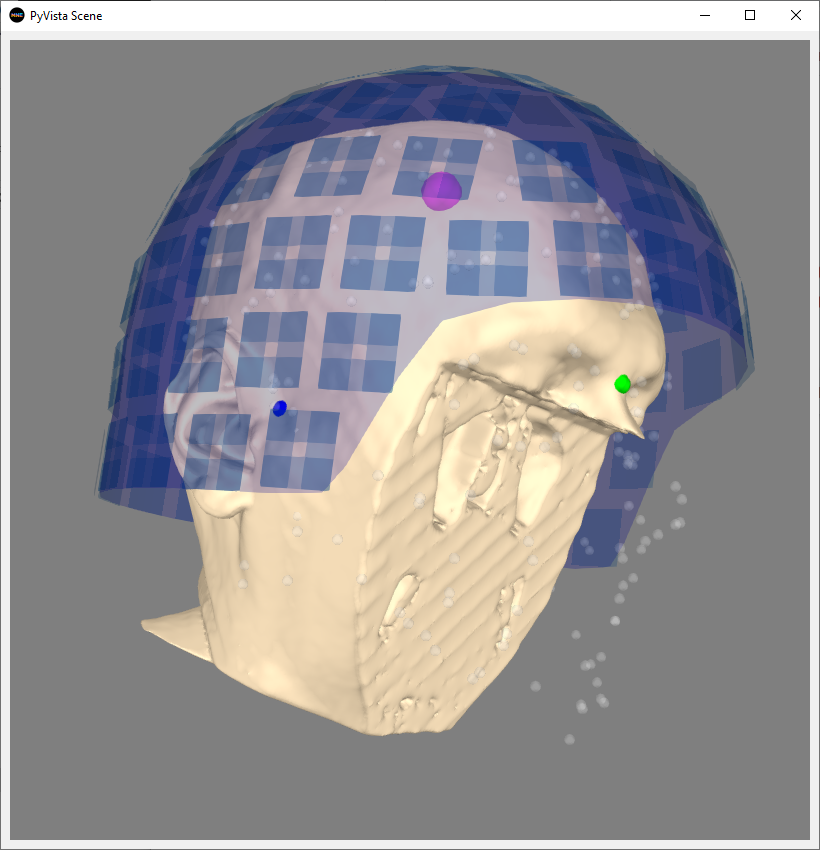

Here its important to check that the fiducial points by the nasium and the preauriculars are well placed. 

## Computing the sources according to the BEM model

To construct volumetric forward model, the 'source space' must be set up. The source space is defined by a grid (5 mm between grid points) covering the volume of the brain.  

In [17]:
surface = op.join(mri_dir, subject, 'bem', 'inner_skull.surf')
src = mne.setup_volume_source_space(subject, subjects_dir=mri_dir,
                                             surface=surface,
                                             verbose=True)

Boundary surface file : C:\Users\jenseno\Dropbox\FLUX\Development\dataRaw\MRI\training1\bem\inner_skull.surf
grid                  : 5.0 mm
mindist               : 5.0 mm
MRI volume            : C:\Users\jenseno\Dropbox\FLUX\Development\dataRaw\MRI\training1\mri\T1.mgz

Reading C:\Users\jenseno\Dropbox\FLUX\Development\dataRaw\MRI\training1\mri\T1.mgz...

Loaded bounding surface from C:\Users\jenseno\Dropbox\FLUX\Development\dataRaw\MRI\training1\bem\inner_skull.surf (10242 nodes)
Surface CM = (  -0.2  -26.8   24.0) mm
Surface fits inside a sphere with radius   98.1 mm
Surface extent:
    x =  -78.1 ...   76.0 mm
    y = -101.4 ...   67.8 mm
    z =  -59.7 ...   94.9 mm
Grid extent:
    x =  -80.0 ...   80.0 mm
    y = -105.0 ...   70.0 mm
    z =  -60.0 ...   95.0 mm
38016 sources before omitting any.
28128 sources after omitting infeasible sources not within 0.0 - 98.1 mm.
Source spaces are in MRI coordinates.
Checking that the sources are inside the surface and at least    5.0 mm aw

and then save it 

In [10]:
fname_src = 'training1-surface_src.fif' 
mne.write_source_spaces(op.join(mri_dir,fname_src),
                            src,
                            overwrite=True)

Overwriting existing file.
    Write a source space...
    [done]
    Write a source space...
    [done]
    2 source spaces written


To visualize the source set write:

Using surface: C:\Users\jenseno\Dropbox\FLUX\Development\dataRaw\MRI\training1\bem\inner_skull.surf
Using surface: C:\Users\jenseno\Dropbox\FLUX\Development\dataRaw\MRI\training1\bem\outer_skull.surf
Using surface: C:\Users\jenseno\Dropbox\FLUX\Development\dataRaw\MRI\training1\bem\outer_skin.surf


C:\Users\jenseno\Anaconda3\envs\mne\lib\site-packages\mne\viz\utils.py:109: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


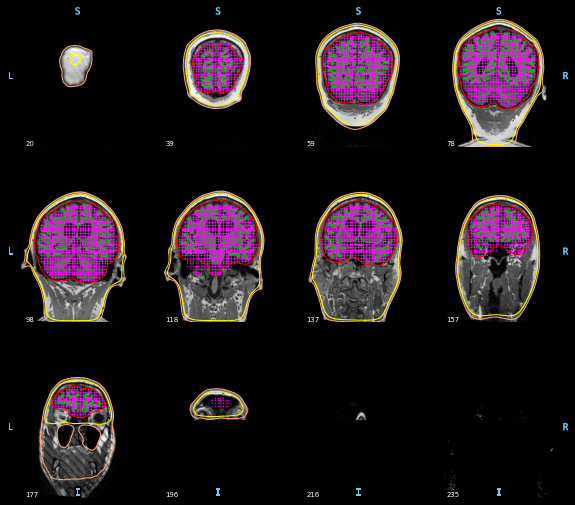

In [18]:
mne.viz.plot_bem(subject=subject, 
                     subjects_dir=mri_dir,
                     brain_surfaces='white', 
                     src=src, 
                     orientation='coronal');

Note that the grid coverts the brain. 

## Construting the forward model

The last step is to construct the forward model by assigning a lead-field to each source location in relation to the head position with respect to the sensors.  This will result in the lead-field matrix (*fwd*) 

In [20]:
fwd = mne.make_forward_solution(path_file, 
                                    trans=trans_file, 
                                    src=src, 
                                    bem=bem,
                                    meg=True, eeg=False, 
                                    mindist=5.,  #TODO: minimum distance of sources from inner skull surface (in mm); can be 2.5
                                    n_jobs = 4, 
                                    verbose=True)

Source space          : <SourceSpaces: [<volume, shape=(33, 36, 32), n_used=12065>] MRI (surface RAS) coords, subject 'training1', ~69.6 MB>
MRI -> head transform : C:\Users\JensenO\Dropbox\FLUX\Development\dataResults\trans.fif
Measurement data      : training_raw-1.fif
Conductor model   : instance of ConductorModel
Accurate field computations
Do computations in head coordinates
Free source orientations

Read 1 source spaces a total of 12065 active source locations

Coordinate transformation: MRI (surface RAS) -> head
     0.996306 -0.056518 -0.064654       0.04 mm
     0.081386  0.861655  0.500927      10.51 mm
     0.027398 -0.504338  0.863071      14.64 mm
     0.000000  0.000000  0.000000       1.00

Read 306 MEG channels from info
105 coil definitions read
Coordinate transformation: MEG device -> head
     0.995222 -0.089575 -0.038852      -1.12 mm
     0.095761  0.973127  0.209411      -7.35 mm
     0.019051 -0.212131  0.977056      39.69 mm
     0.000000  0.000000  0.000000    

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.



    Skipping interior check for 0 sources that fit inside a sphere of radius   48.6 mm
    Skipping solid angle check for 306 points using Qhull
Setting up compensation data...
    No compensation set. Nothing more to do.

Composing the field computation matrix...


[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    1.2s remaining:    1.2s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    1.2s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    1.2s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.3s remaining:    0.3s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.3s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.3s remaining:    0.3s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.3s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Computing MEG at 12065 source locations (free orientations)...


[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.3s remaining:    0.3s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.4s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.8s remaining:    0.8s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    1.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.4s remaining:    0.4s
[Para


Finished.


(in the above *n_jobs = 4*. If *n_jobs* was not set, the algorithm crashed).

Finally, save the forward models:

In [21]:
fname_fwd = op.join(mri_dir,
                        subject+'-volume_fwd.fif' )

mne.write_forward_solution(fname_fwd,
                               fwd,
                               overwrite=True)

    Write a source space...
    [done]
    1 source spaces written


## Preregistraion and publications

Publication, example:

"Structural magnetic resonance images (MRIs) were acquired using a 3 Tesla Siemens MAGNETOM Prisma whole-body scanner (Siemens AG; TE = 2 ms, and TR = 2 s). The raw T1 weighted images were converted from DICOM to NIFTI. The MRIs were de-faced to anonymize the participant. The coordinate system of the participants' individual MRI was aligned to the anatomic landmarks (nasion as well as the left and right preauricular points) and the scalp shapes digitized before the recordings. The alignment according to the MEG sensor array was done relative to four digitized head position indicator (HPI) coils. A single shell boundary elements model (BEM) was constructed based on the brain surface derived using Freesurfer (Dale et al., 1999; Destrieux et al., 2010). This was then used to construct a volumetric forward model (5 mm grid) covering the full brain volume. The lead field matrix was then calculated according the head-position with respect to MEG sensor array. "


## References 

Dale, A.M., Fischl, B., and Sereno, M.I. (1999). Cortical surface-based analysis: I. segmentation and surface reconstruction. NeuroImage, 9(2):179–194. 
 
Destrieux, C., Fischl, B., Dale, A., and Halgren, E. (2010) Automatic parcellation of human cortical gyri and sulci using standard anatomical nomenclature. NeuroImage, 53(1):1–15.
